In [27]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
from acoustic_entrainment import VelocityResponse, muflown_response, muflown_sensitivity, mic_response
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from brownian import abc_guess, get_krhoA, psd_func, logbin_func, get_sound_speed, psd_abc_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import numpy as np

from os import path

from matplotlib import rc
fontsize = 10
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
    "text.latex.preamble":r'\usepackage{upgreek}' 
}

plt.rcParams.update(fontstyle)
letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)


# New function definitions

In [28]:
def sort_fnames(fnames, include=None, exclude=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    if exclude is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr not in exclude]
    return fnames_sorted

from constants import kB
from scipy.integrate import cumulative_trapezoid

reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

def psd_calibration(fname, channel="X",
                   fmin=5e2, fmax=4e4, cutoff=1e6,  taumax=100e-3,freq_xnoise2=2e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    C = Collection(fname)
    C.set_collection(channel)
    C.R = 1.51e-6
    Tavg = np.mean(C.T)
    if Tavg < 273.15:
        Tavg += 273.15
    Npts = int(C.r / (2*cutoff))
    C.apply("detrend", inplace=True, mode="constant")
    #C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    
    fun = make_objective(psd_abc_func, freq[mask], psd[mask], C.Navg_psd)
    res = minimize(fun, abc, method="Nelder-Mead")
    abc = res.x
    
    cal_params = get_params_from_abcRT(*abc, C.R, Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>freq_xnoise2])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker="o", ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq[1:], plot_psd[1:], **dplot_kwargs)
        
        fplot_kwargs = dict(c=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        #ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

def deg2rad(x):
    return x * np.pi / 180


def rad2deg(x):
    return x * 180 / np.pi

def radian_labels(ax, denoms=[-1, -2, 0, 2, 1], skip=1):
    rads = [np.pi/d if d!=0 else 0 for d in denoms]
    rad_labels = [r"$-\pi/%s$" % abs(d) if d<-1 \
             else r"$\pi/%s$" % abs(d) if d>1 \
             else "$-\pi$" if d == -1 \
             else "$\pi$" if d == 1 \
             else "$0$" for d in denoms]
    return rads, rad_labels
    

def dB_re(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return deci * np.log10(x/ref)

def db_re_inverse(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return ref * 10**(x/deci)


def SPL(x):
    return dB_re(x, ref=20e-6, typ="pressure")


def slope(x, m):
    return x/m



def slope_quad(x, a, b):
    return a*x + b*x*x

def powerlaw(x, a, m):
    return a * x**m

def exponential(x, a, m):
    return a * np.e**(x/m)

def find_pulse_points(time_series, tmin, tmax, factor=0.0, nozeros=False): 
    ts, xs = time_series.time_gate(tmin, tmax)
    # trough
    troughdex = np.argmin(xs)
    ttrough = ts[troughdex]
    xtrough = xs[troughdex]
    #peak
    peakdex = np.argmax(xs[ts<ttrough])
    tpeak = ts[ts<ttrough][peakdex]
    xpeak = xs[ts<ttrough][peakdex]
    if nozeros:
        tpoints = [0, tpeak, 0, ttrough, 0]
        xpoints = [0, xpeak, 0, xtrough, 0]
        return tpoints, xpoints
        
    # zeros
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xpeak)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    ## left
    peak_minus_zeros = tpeak - tzeros
    left_zeros_mask = peak_minus_zeros > 0
    left_zero = tzeros[left_zeros_mask][np.argmin(peak_minus_zeros[left_zeros_mask])]
    ## right
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xtrough)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    zeros_minus_trough = tzeros - ttrough
    right_zeros_mask =  zeros_minus_trough > 0
    right_zero = tzeros[right_zeros_mask][np.argmin(zeros_minus_trough[right_zeros_mask])]
    ## middle
    pre_zerodex = np.where(np.diff(np.sign(xs)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    mid_zero = tzeros[np.logical_and(tzeros>tpeak, tzeros<ttrough)][0]
    # important points
    tpoints = [left_zero, tpeak, mid_zero, ttrough, right_zero]
    xpoints = [factor*xpeak, xpeak, 0, xtrough, factor*xtrough]
    return tpoints, xpoints


def make_musphere_response(C0, impedance=None, r0=3e-2, response="bassetbound"):
    T = np.mean(C0.T)
    VR = VelocityResponse(1/C0.cal, C0.R, C0.rho, T, C0.k,C0.cRH)
    if impedance is None:
        _response = lambda f:VR.response(response, f)
    else:
        impedance = getattr(VR, f"{impedance}_impedance")
        _response = lambda f:VR.response(response, f)/impedance(f, r0)
    return _response



def load_collection(fname, channel, response, differentiate, 
                    scale=1, cutoff=None, Npts="cutoff", shift=0, invert=False, 
                    tmin=None, tmax=None, window="boxcar", detrend="constant"):
    C = Collection(fname)
    C.set_collection(channel)
    C.apply("calibrate", cal=scale, inplace=True)
    if cutoff is not None:
        C.apply("lowpass", cutoff=cutoff, inplace=True)
    if Npts is not None:
        if Npts == "cutoff":
            if cutoff is not None:
                Npts=int(C.r/(2*cutoff))
            else:
                Npts = None
        C.apply("bin_average", Npts=Npts, inplace=True)
    if response is not None:
        C.apply("correct", response=response, n_jobs=1, tmin=tmin, tmax=tmax, 
            window=window, differentiate=differentiate, recollect=True)
    if response is None and differentiate:
        C.apply("differentiate", inplace=True)
        
    if detrend is not None:
        C.apply("detrend", mode=detrend, inplace=True)
    C.apply("shift", tau=shift, inplace=True)
    if invert:
        C.apply("calibrate", cal=-1, inplace=True)
    return C

def make_objective(model, freq, psd, n):
    """ Construct negative log-likelihood objective function"""
    #c = np.sum(np.log(gamma(n)) - n*np.log(n)-(n-1)*np.log(psd))
    def objective(popts):
        model_psd = model(freq, *popts)
        obj = n*np.sum(np.log(model_psd) + psd/model_psd)
        #obj+=c
        return obj
    return objective
       

# Directory structure

In [29]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20220707',
 '/data/brownian/20211215',
 '/data/brownian/20220720',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20221019',
 '/data/brownian/20220525',
 '/data/brownian/20220614',
 '/data/brownian/20220628',
 '/data/brownian/20220726',
 '/data/brownian/20220722',
 '/data/brownian/20220715',
 '/data/brownian/20220523']

In [30]:
# Select a date
date_der_index = -3
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20220722/bead1']

In [31]:
# Select a date
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20220722/bead1/slow-phone_hi-respos-scan_1ms-delay_V2',
 '/data/brownian/20220722/bead1/slow-phone_baseline',
 '/data/brownian/20220722/bead1/slow-phone_baseline_V2',
 '/data/brownian/20220722/bead1/slow-phone_hi-res-pos-scan_1ms-delay_V3',
 '/data/brownian/20220722/bead1/slow-phone_1000-shots_ene-scan',
 '/data/brownian/20220722/bead1/slow-phone_baseline_V3',
 '/data/brownian/20220722/bead1/slow-phone_ene-pos-scan_1ms-delay',
 '/data/brownian/20220722/bead1/slow-phone_ene-pos-scan_1ms-delay_V2']

# Bead calibration

In [32]:
baseline_experiment_index = [1,2,5]
baseline_fnames = find_files(experiment_ders[baseline_experiment_index[0]])
for experiment_der_index in baseline_experiment_index[1:]:
    next_fnames = find_files(experiment_ders[experiment_der_index])
    for fname in next_fnames:
        baseline_fnames.append(fname)

[2.336128553033574e-05, 1717.7799085125196, 6.652332651998075e-07, 296.9174201920419, 41.02702421153316, 31.372535010109935]
[2.2905543213832035e-05, 1691.8860023240825, 6.618799717724823e-07, 296.91737925016963, 41.01929499875597, 31.352546168761144]
[2.2434077480018145e-05, 1677.1811288769304, 7.047519454088971e-07, 296.90783186376285, 40.998869587916104, 31.3691884251384]
[2.3324282893135555e-05, 1725.2801576671068, 6.805175402800473e-07, 296.9171143581236, 41.01765758142093, 31.361776964486346]
[2.2586179401311932e-05, 1668.4924879692567, 7.145288946385585e-07, 296.9025008654571, 40.99587207609039, 31.359363537292477]
[2.3014949100150285e-05, 1720.1631445851763, 7.168838261372583e-07, 296.8661226147541, 40.983800545142, 31.310671725039754]
[2.3481841395780974e-05, 1744.6413081927092, 7.094103556630355e-07, 296.891018085386, 40.9840960662785, 31.366940138365038]
[2.2666762873205514e-05, 1679.875087872157, 7.096167712891923e-07, 296.9018237273602, 40.9868816355479, 31.354081996808965

/home/lhillber/documents/research/brownian/notebooks/../src/brownian.py:391: RuntimeWarning: invalid value encountered in divide
  Sinvmat = C / Denom


[nan, nan, nan, 297.1057539574988, 41.00787197792847, 31.383359643429827]
[2.0643530075587182e-05, 1622.3330829593858, 4.0660811668844885e-07, 297.1213853789999, 41.00687963847274, 31.376753362294608]
[2.174595261782524e-05, 1687.3975148757845, 3.961204697449609e-07, 297.1152247845591, 41.007741131095194, 31.379749247182396]
[2.096160110974987e-05, 1651.0044018681815, 3.9810273262525114e-07, 297.1331504928694, 41.01213078025613, 31.39508576479053]
[2.166493244482499e-05, 1670.3554779937526, 4.020616154794489e-07, 297.1208591933839, 41.00982305252482, 31.380970134654273]


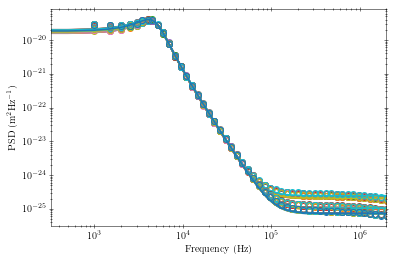

In [33]:
fmin = 2e3
fmax = 3e4
cutoff = 2000e3
taumax = 2e-3

fig, ax = plt.subplots(1,1, figsize=(6,4))

krhoCalTs = []
for fnamei, fname in enumerate(baseline_fnames[:]):
    color = f"C{fnamei}"
    C0, ax = psd_calibration(fname, taumax=taumax, fmin=fmin, fmax=fmax, cutoff=cutoff,
                             plot=True, ax=ax, color=color)
    krhoCalTs.append([C0.k, C0.rho, C0.cal, C0.Tavg, np.mean(C0.PDF), np.mean(C0.PDB)])   
    print(krhoCalTs[fnamei])
krhoCalTs = np.array(krhoCalTs)

k : 22.1159054280334 0.8140511286464068 3.6808401595647187
rho : 1687.381075502225 28.69571587762926 1.7006067149999529
cal : 0.5249321115441837 0.1266604683848853 24.128923645438714
T : 23.889213360869103 0.09650898798029094 0.4039856253214856
P : 72.30425358127916 0.17389827902768507 0.240509057786208


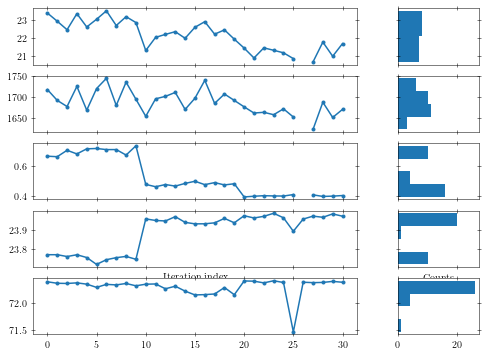

In [34]:
fig, axs = plt.subplots(5,2, figsize=(8, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "cal", "T", "P"]):
    vals = krhoCalTs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="cal":
        vals = vals * 1e9 / 1e3
    if param == "T":
        vals = vals -273.15
    if param == "P":
        vals =krhoCalTs[:, parami]+krhoCalTs[:, parami+1]
    
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    #axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.nanmean(vals), np.nanstd(vals), 100*np.nanstd(vals)/np.nanmean(vals))
R = C0.R

# Bandwidth selection

# Slow phone position and energy scan

In [35]:
laser_delay = 1000e-6
pos0 = 4.4
c0 = get_sound_speed(T=C0.Tavg, RH=C0.cRH, p=C0.cP)

In [36]:
experiment_ders

['/data/brownian/20220722/bead1/slow-phone_hi-respos-scan_1ms-delay_V2',
 '/data/brownian/20220722/bead1/slow-phone_baseline',
 '/data/brownian/20220722/bead1/slow-phone_baseline_V2',
 '/data/brownian/20220722/bead1/slow-phone_hi-res-pos-scan_1ms-delay_V3',
 '/data/brownian/20220722/bead1/slow-phone_1000-shots_ene-scan',
 '/data/brownian/20220722/bead1/slow-phone_baseline_V3',
 '/data/brownian/20220722/bead1/slow-phone_ene-pos-scan_1ms-delay',
 '/data/brownian/20220722/bead1/slow-phone_ene-pos-scan_1ms-delay_V2']

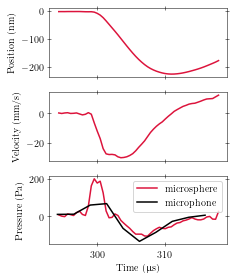

In [39]:
fnames_ph = sort_fnames(find_files(experiment_ders[6]))
fnamei = 70
fname = fnames_ph[fnamei]
cutoff = 1000e3

Cx = Collection(fname)
Cv = Collection(fname)
Cp = Collection(fname)
Cmic = Collection(fnames_ph[fnamei])
musphere_response = make_musphere_response(C0, response="bassetbound", impedance="plane", r0=0)
  

Cx = load_collection(fname, "X", None, differentiate=False, 
                    cutoff=cutoff, Npts="cutoff", shift=laser_delay, invert=True, 
                    window="boxcar", detrend="constant")
Cx.apply("calibrate", cal=C0.cal, inplace=True)

Cv = load_collection(fname, "X", None, differentiate=True, 
                    cutoff=cutoff, Npts="cutoff", shift=laser_delay, invert=True, 
                    window="boxcar", detrend="constant")
Cv.apply("calibrate", cal=C0.cal, inplace=True)

Cp = load_collection(fname, "X", musphere_response, differentiate=True, 
                    cutoff=cutoff, Npts="cutoff", shift=laser_delay, invert=True, 
                    window="boxcar", detrend="constant")

Cmic = load_collection(fname, "Y", mic_response, differentiate=False, 
                    cutoff=200e3, Npts="cutoff", shift=laser_delay+15e-6, invert=False, 
                    window="boxcar", detrend="constant")


for C in [Cx, Cv, Cp, Cmic]:
    C.aggrigate()

tmin = 294e-6
tmax = 318e-6

fig, axs =plt.subplots(3, 1, sharex=True, figsize=(3.375, 4))
Cx.agg.plot(ax=axs[0], tmin=tmin,tmax=tmax, tunit="us", unit="nm", c="crimson")
Cv.agg.plot(ax=axs[1], tmin=tmin,tmax=tmax, tunit="us", unit="mm_s", c="crimson")
Cp.agg.plot(ax=axs[2], tmin=tmin,tmax=tmax, tunit="us", unit="Pa", label="microsphere", c="crimson")
Cmic.agg.plot(ax=axs[2], tmin=tmin,tmax=tmax, tunit="us", unit="Pa", label="microphone", c="k")
axs[0].set_ylabel("Position (nm)")
axs[0].set_xlabel("")
axs[1].set_ylabel("Velocity (mm/s)")
axs[1].set_xlabel("")
axs[2].set_ylabel("Pressure (Pa)")
axs[2].legend()
plt.tight_layout()
#plt.savefig("figures/pulsed_laser_analysis_sequence.pdf")
#plt.savefig("figures/pulsed_laser_analysis_sequence.png", dpi=600)

In [408]:
Cx = Collection(fname)
Cx.set_collection("X")
Cx.t[-1]*1e3

2.6214

In [589]:
fnames_ph = sort_fnames(find_files(experiment_ders[6]))
musphere_response = make_musphere_response(C0, response="bassetbound", impedance="plane", r0=0)
bd_cutoff = 1000e3

enes = []
poss = []
for fname in fnames_ph:
    C = Collection(fname)
    poss.append(C.pos)
    enes.append(C.ene)
poss = np.unique(poss)
abs_pos = poss + pos0
enes = np.unique(enes)

enes = enes[:]
fnamei = len(poss)
Cbds = np.zeros((len(enes), len(poss)), dtype="object")
Cphs = np.zeros((len(enes), len(poss)), dtype="object")
fnamei=0
for enei, ene in enumerate(enes):
    for posi, pos in enumerate(poss):
        fname = fnames_ph[fnamei]
        Cbd = load_collection(fname, "X", musphere_response, 
                      differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=laser_delay, invert=True)
        Cph = load_collection(fname, "Y", mic_response, 
                      differentiate=False, cutoff=200e3, Npts="cutoff", shift=laser_delay+15e-6, invert=False)
        Cbd.aggrigate()
        Cph.aggrigate()
        fnamei += 1
        Cbds[enei, posi] = Cbd
        Cphs[enei, posi] = Cph
        
        

In [590]:
abs_pos.size

30

In [591]:
4.4+(abs_pos[1] - abs_pos[0])*29, abs_pos[-1]

(10.399999999999999, 10.4)

13.0 9.572413793103449


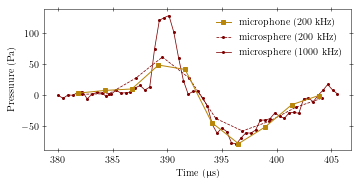

In [574]:

collection_slice = slice(0,13,1)
fig, ax = plt.subplots(1,1, figsize=(5.5, 2.6))

tmin= 233e-6
tmax = 256e-6
fname = sort_fnames(find_files(experiment_ders[6]))[85-25]


tmin= 380e-6
tmax = 406e-6
fname = sort_fnames(find_files(experiment_ders[6]))[85]


musphere_response = make_musphere_response(C0, response="bassetbound", impedance="plane")
Cph = load_collection(fname, "Y", mic_response, 
                          differentiate=False, cutoff=200e3, Npts="cutoff", shift=laser_delay+15e-6, invert=False)
Cph.aggrigate(collection_slice=collection_slice)
Cph.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us", zorder=10,
                marker="s", ms=4, lw=1, label=f"microphone (200 kHz)", c="darkgoldenrod")

print(Cph.ene, Cph.pos+pos0)

for ls, BW in zip(["--", "-", ":"], [200e3,1000e3]):
    Cbd = load_collection(fname, "X", musphere_response, 
                          differentiate=True, cutoff=BW, Npts="cutoff",
                          shift=laser_delay, invert=True)
    Cbd.aggrigate(collection_slice=collection_slice)
    #pulse_params(Cbd.agg, tmin, tmax)
    Cbd.agg.plot(ax=ax, tmin=tmin, tmax=tmax, ls=ls, unit=1, tunit="us", label=f"microsphere ({int(BW/1e3)} kHz)",
                 marker="o",color="maroon", ms=2, lw=0.75)
ax.set_ylabel("Pressuure (Pa)")
plt.legend(frameon=False, handlelength=1.5)
#plt.savefig("figures/pulsed_laser_microphone_bandwidth.pdf")
plt.savefig("figures/dissertation/pulsed_laser_microphone_bandwidth.pdf", dpi=600)

In [599]:
kB*300/(21.5e-9)**2

8.962682531097888e-06

In [592]:
import matplotlib.gridspec as gridspec

t0 = 220e-6
Dt = 50e-6
factor = 0.1

Nshots = 10
shots = list(range(Nshots)) + ["avg"]
shots=[0, 1, "avg"]


pulse_timings = np.zeros((2, len(enes), len(poss), len(shots), 4))
pulse_peaks = np.zeros((2, len(enes), len(poss), len(shots), 4))


for enei, ene in enumerate(enes[:]):
    for posi, pos in enumerate(poss):
        Cbd = Cbds[enei, posi]
        Cph = Cphs[enei, posi]
        assert Cbd.ene == ene and Cph.ene == ene and Cbd.pos == pos and Cph.pos == pos
        #Cbd.aggrigate(collection_slice=25)
        #Cph.aggrigate(collection_slice=25)
        for Ci, C in enumerate((Cbd, Cph)):
            for shoti, shotnum in enumerate(shots):
                if shotnum == "avg":
                    D = C.agg
                else:
                    D = C.collection[shotnum]
                # initial window
                tmin = t0 + pos*1e-2/c0
                tmax = t0 + pos*1e-2/c0 + Dt
                # refine window
                #t, x = D.time_gate(tmin=200e-6, tmax=600e-6)
                #ttrough = t[np.argmax(x)]
                #tmin = ttrough - 40e-6
                #tmax = ttrough + 40e-6
                ts, xs = D.time_gate(tmin, tmax)
                try:
                    timings, peaks = pulse_params(D, tmin=tmin, tmax=tmax, factor=factor)
                except:
                    timings, peaks = [0,0,0,0], [0,0,0,0]
                    print("fail")
                    print(ene, pos, shotnum)
                    print()
                    plt.plot(ts, xs)
                    plt.show()
                pulse_timings[Ci, enei, posi, shoti, :] = timings
                pulse_peaks[Ci, enei, posi, shoti, :] = peaks


In [593]:
def plot_series(ax, plot_eneis, plot_posis, plot_Cis, shotnum, pulse_peaks):
    for enei, ene in enumerate(enes[:]):
        #enei+=1
        alpha = (ene/enes[-1])**6
        for posi, pos in enumerate(poss):
            Cbd = Cbds[enei, posi]
            Cph = Cphs[enei, posi]
            for Ci, C in enumerate((Cbd,Cph)):
                if shotnum in (-1, "avg"):
                    D = C.agg
                    shoti = -1
                else:
                    D = C.collection[shotnum]
                    shoti = shotnum
                tpeak, Ppeak, ttrough, Ptrough = pulse_peaks[Ci, enei, posi, shotnum, :]
                if Ci == 0:
                    marker = "o"
                    ls = "-"
                    c = "maroon"
                    label = "Microsphere"
                if Ci == 1:
                    marker = "s"
                    ls = "-"
                    c = "darkgoldenrod"
                    label = "Microphone"
                tmin = ttrough - 15e-6
                tmax = ttrough + 15e-6
                ts, xs = D.time_gate(tmin, tmax)
                if posi in plot_posis and enei in plot_eneis and Ci in plot_Cis:
                    D.plot(ax=ax, tmin=ttrough-15e-6, tmax=ttrough+10.5e-6, label=label,
                       tunit="us", unit="Pa", zorder=posi, ls=ls, c=c, alpha=alpha, lw=0.5)

In [594]:
np.arange(0,30,5, dtype=int)

array([ 0,  5, 10, 15, 20, 25])

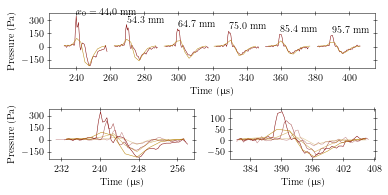

In [595]:
import matplotlib.ticker as ticker


plot_posis = np.arange(0,30,5, dtype=int)
plot_Cis = [0, 1]
shotnum=-1
color_set =  plt.cm.tab20b(np.arange(4*len(plot_posis)))
colors = {}
for ppi, plot_posi in enumerate(plot_posis):
    for Ci in range(2):
        colors[plot_posi+Ci] = color_set[ppi*4 + (1-Ci)*2]



fig = plt.figure(figsize=(5.5, 2.8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1.1, 1])
ax = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
axs = [ax1, ax2]


plot_eneis = [2]
plot_series(ax, plot_eneis, plot_posis, plot_Cis, shotnum, pulse_peaks)

ax.set_ylabel("Pressure (Pa)")
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

first = True
for posi, pos in enumerate(abs_pos):
    if posi in plot_posis:
        if first:
            label = "$x_0=%s$ mm"%round(pos*10, 1)
        else:
            label = "%s mm"%round(pos*10, 1)
        tpeak, peak, ttrough, trough = pulse_peaks[plot_Cis[0], plot_eneis[0], posi, -1, :]
        ax.text(tpeak*1e6 , peak, label, ha="left", va="bottom")
        first = False
    

plot_eneis = [0,1, 2]
plot_posis = [0]
plot_series(axs[0], plot_eneis, plot_posis, plot_Cis, shotnum, pulse_peaks)
axs[0].set_ylabel("Pressure (Pa)")
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(5))
axs[0].yaxis.set_major_locator(ticker.MaxNLocator(5))

plot_eneis = [0,1,2]
plot_posis = [25]
plot_series(axs[1], plot_eneis, plot_posis, plot_Cis, shotnum, pulse_peaks)
axs[1].set_ylabel(None)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(5))
axs[1].yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.tight_layout()
plt.savefig(f"figures/dissertation/laser-pos-ene-scan_time_series.pdf")
#plt.savefig(f"figures/laser-pos-ene-scan_time_series.png", dpi=600)


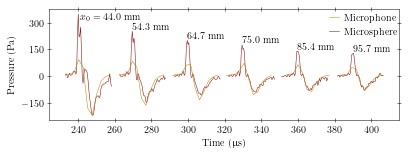

In [596]:

fig, ax = plt.subplots(1,1, figsize=(5.5, 2))


plot_posis = np.arange(0,30,5, dtype=int)
plot_Cis = [0, 1]
shotnum=-1
plot_eneis = [2]
plot_series(ax, plot_eneis, plot_posis, plot_Cis, shotnum, pulse_peaks)

ax.set_ylabel("Pressure (Pa)")
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

first = True
for posi, pos in enumerate(abs_pos):
    if posi in plot_posis:
        tpeak, peak, ttrough, trough = pulse_peaks[plot_Cis[0], plot_eneis[0], posi, -1, :]
        if first:
            label = "$x_0=%s$ mm"%round(pos*10, 1)
            y0 = peak - 40
            x0=tpeak*1e6 + 1
        else:
            label = "%s mm"%round(pos*10, 1)
            y0=peak
            x0=tpeak*1e6
        
        ax.text(x0 , y0, label, ha="left", va="bottom")
        first = False

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(list(by_label.values())[::-1], list(by_label.keys())[::-1], loc='upper right', 
           frameon=False, handlelength=1, handletextpad=0.5, bbox_to_anchor=(1.02,1.035))
plt.tight_layout(pad=0.1)
plt.savefig(f"figures/dissertation/laser-pos-scan_time_series.pdf")
#plt.savefig(f"figures/laser-pos-ene-scan_time_series.png", dpi=600)

In [583]:
def fit_powerlaw(x, y, dy, p0):
    popt, pcov = curve_fit(powerlaw, x, y, p0=p0, sigma=dy, absolute_sigma=True,
                                     bounds=[(-np.inf, -np.inf), (np.inf, np.inf)])
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def fit_line(x, y, dy):
    speed = np.mean(np.diff(x) / np.diff(y))
    popt, pcov = curve_fit(line, x, y, p0=[speed, x[0]], sigma=dy, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    return popt, perr


def line(x, speed, x0):
    return (x-x0)/speed


In [584]:
def get_pulse_timings_meta(bd_cutoff):
    fnames_ph = sort_fnames(find_files(experiment_ders[6]))
    musphere_response = make_musphere_response(C0, response="stokesbound", impedance="plane", r0=0)


    enes = []
    poss = []
    for fname in fnames_ph:
        C = Collection(fname)
        poss.append(C.pos)
        enes.append(C.ene)
    poss = np.unique(poss)
    abs_pos = poss + pos0
    enes = np.unique(enes)

    enes = enes[:]
    fnamei = len(poss)
    Cbds = np.zeros((len(enes), len(poss)), dtype="object")
    Cphs = np.zeros((len(enes), len(poss)), dtype="object")
    fnamei=0
    for enei, ene in enumerate(enes):
        for posi, pos in enumerate(poss):
            fname = fnames_ph[fnamei]
            Cbd = load_collection(fname, "X", musphere_response, 
                          differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=laser_delay, invert=True)
            Cph = load_collection(fname, "Y", mic_response, 
                          differentiate=False, cutoff=200e3, Npts="cutoff", shift=laser_delay+15e-6, invert=False)
            Cbd.aggrigate()
            Cph.aggrigate()
            fnamei += 1
            Cbds[enei, posi] = Cbd
            Cphs[enei, posi] = Cph

            import matplotlib.gridspec as gridspec

    t0 = 220e-6
    Dt = 50e-6
    factor = 0.1

    Nshots = 10
    shots = list(range(Nshots)) + ["avg"]
    shots=[0, 1, "avg"]


    pulse_timings = np.zeros((2, len(enes), len(poss), len(shots), 4))
    pulse_peaks = np.zeros((2, len(enes), len(poss), len(shots), 4))


    for enei, ene in enumerate(enes[:]):
        for posi, pos in enumerate(poss):
            Cbd = Cbds[enei, posi]
            Cph = Cphs[enei, posi]
            assert Cbd.ene == ene and Cph.ene == ene and Cbd.pos == pos and Cph.pos == pos
            #Cbd.aggrigate(collection_slice=25)
            #Cph.aggrigate(collection_slice=25)
            for Ci, C in enumerate((Cbd, Cph)):
                for shoti, shotnum in enumerate(shots):
                    if shotnum == "avg":
                        D = C.agg
                    else:
                        D = C.collection[shotnum]
                    # initial window
                    tmin = t0 + pos*1e-2/c0
                    tmax = t0 + pos*1e-2/c0 + Dt
                    # refine window
                    #t, x = D.time_gate(tmin=200e-6, tmax=600e-6)
                    #ttrough = t[np.argmax(x)]
                    #tmin = ttrough - 40e-6
                    #tmax = ttrough + 40e-6
                    ts, xs = D.time_gate(tmin, tmax)
                    try:
                        timings, peaks = pulse_params(D, tmin=tmin, tmax=tmax, factor=factor)
                    except:
                        timings, peaks = [0,0,0,0], [0,0,0,0]
                        print("fail")
                        print(ene, pos, shotnum)
                        print()
                        plt.plot(ts, xs)
                        plt.show()
                    pulse_timings[Ci, enei, posi, shoti, :] = timings
                    pulse_peaks[Ci, enei, posi, shoti, :] = peaks
    return pulse_timings, pulse_peaks

In [585]:
pulse_timings200, pulse_peaks200 = get_pulse_timings_meta(200e3)


[ 2.12070107e+03 -1.25857668e+00] 0.9133956545299838
[187.54998518  -0.50521889] 6.584899082412139
[479.27964875  -0.84307155] 3.7298383285522734


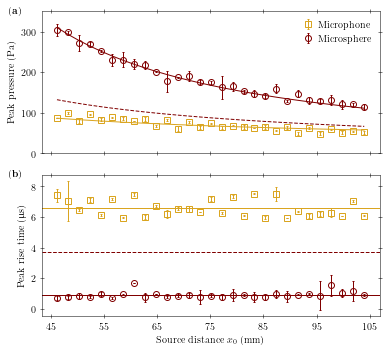

In [597]:
shoti = -1
fig, axs = plt.subplots(2, 1, figsize=(5.5, 5), sharex=True)
ene_names = enes
pos_mask = abs_pos >= abs_pos[1]
use_pos = abs_pos[pos_mask]



ene = enes[2]
c = f"C{1-eni}"
fc = c
enei = list(enes).index(ene)
ene_name = ene_names[eni]


for Ci in range(2):
    if Ci == 0:
        marker="o"
        ls = "-"
        sensor = "Microsphere"
        c="maroon"
    else:
        marker="s"
        ls = "-"
        sensor = "Microphone"
        c= "goldenrod"

    dt_f, Dt_f, dt_r, Dt_r = [pulse_timings[Ci, enei, pos_mask, shoti, i] for i in range(4)]
    ddt_f, dDt_f, ddt_r, dDt_r = [np.std(pulse_timings[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
    tpeak, Ppeak, ttrough, Ptrough = [pulse_peaks[Ci, enei, pos_mask, shoti, i] for i in range(4)]
    dtpeak, dPpeak, dttrough, dPtrough = [np.std(pulse_peaks[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]        
    dtpeak  = np.sqrt(dtpeak**2 + (1/(bd_cutoff*2))**2)
    dttrough  = np.sqrt(dttrough**2 + (1/(bd_cutoff*2))**2)

    popt_Ppeak, perr_Ppeak = fit_powerlaw(use_pos, Ppeak, dPpeak, [10000.0, -1.0])
    popt_tpeak, perr_tpeak = fit_line(use_pos, tpeak*1e6, dtpeak*1e6)
    #popt_tpeak0 = [(c0*1e2/1e6), popt_tpeak[1]]
    popt_dt_f, perr_dt_f = fit_powerlaw(use_pos, dt_f, ddt_f, [10.0, 1.0])
    popt_Dt_f, perr_Dt_f = fit_powerlaw(use_pos, Dt_f, dDt_f, [10.0, 1.0])

    popt_Ptrough, perr_Ptrough = fit_powerlaw(use_pos, Ptrough, dPtrough, [-10000.0, -1.0])
    popt_ttrough, perr_ttrough = fit_line(use_pos, ttrough*1e6, dttrough)
    popt_ttrough0 = [c0*1e2/1e6, popt_ttrough[1]]
    popt_dt_r, perr_dt_r = fit_powerlaw(use_pos, dt_r, ddt_r, [10.0, 1.0])
    popt_Dt_r, perr_Dt_r = fit_powerlaw(use_pos, Dt_r, dDt_r, [10.0, 1.0])


    axs[0].errorbar(use_pos*10, Ppeak, yerr=dPpeak, elinewidth=1, capsize=1,
                      mec=c, mfc="none", ecolor=c, ls="none", lw=1, mew=1,
                    ms=6, marker=marker, label=sensor)     
    axs[0].plot(use_pos*10, powerlaw(use_pos, *popt_Ppeak), 
                    lw=1, mew=1, c=c, ls="-")
                    #label="$x_0^{%.1f}$" % (popt_Ppeak[1]))
                   #label="$x_0^{%s \pm %s}$" % (round(popt_Ppeak[1],2), round(perr_Ppeak[1],2)))

    axs[1].errorbar(use_pos*10, 1e6*dt_f, yerr=1e6*ddt_f, elinewidth=1, capsize=1, 
                       mec=c, mfc="none", ecolor=c, ls="none", 
                       lw=1, ms=6, mew=1, marker=marker)
    axs[1].axhline(np.mean(dt_f*1e6), color=c, lw=1)
    print(popt_Ppeak, np.mean(dt_f*1e6))
    
    
    
dt_f200, Dt_f200, dt_r200, Dt_r200 = [pulse_timings200[0, enei, pos_mask, shoti, i] for i in range(4)]
ddt_f200, dDt_f200, ddt_r200, dDt_r200 = [np.std(pulse_timings200[0, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
tpeak200, Ppeak200, ttrough200, Ptrough200 = [pulse_peaks200[0, enei, pos_mask, shoti, i] for i in range(4)]
dtpeak200, dPpeak200, dttrough200, dPtrough200 = [np.std(pulse_peaks200[0, enei, pos_mask, :-1, i], axis=1) for i in range(4)]        
dtpeak200  = np.sqrt(dtpeak200**2 + (1/((200e3)*2))**2)
dttrough200  = np.sqrt(dttrough**2 + (1/(200e3*2))**2)

c="maroon"
marker = "o"
popt_Ppeak200, perr_Ppeak200 = fit_powerlaw(use_pos, Ppeak200, dPpeak200, [10000.0, -1.0])
print(popt_Ppeak200, np.mean(dt_f200*1e6))
popt_dt_f200, perr_dt_f200 = fit_powerlaw(use_pos, dt_f200, ddt_f200, [10.0, 1.0])
#axs[0].errorbar(use_pos*10, Ppeak200, yerr=dPpeak200, elinewidth=1, capsize=1,
#                    mec=c, mfc="none", ecolor=c, ls="none", lw=1, mew=0.75,
#                    ms=4, marker=marker,label=sensor)  
axs[0].plot(use_pos*10, powerlaw(use_pos, *popt_Ppeak200), 
                    lw=1, mew=0.5, c=c, ls="--", zorder=10)

                    #label="$x_0^{%.1f}$" % (popt_Ppeak[1]))
                   #label="$x_0^{%s \pm %s}$" % (round(popt_Ppeak[1],2), round(perr_Ppeak[1],2)))

#axs[1].errorbar(use_pos*10, 1e6*dt_f200, yerr=1e6*ddt_f200, elinewidth=1, capsize=1, 
#                       mec=c, mfc="none", ecolor=c, ls="none", 
#                       lw=1, ms=4, mew=0.75, marker=marker, zorder=1-Ci)
axs[1].axhline(np.mean(dt_f200*1e6), color=c, lw=1, ls="--", zorder=0)


handles, labels = axs[0].get_legend_handles_labels()

axs[0].legend(handles[::-1], labels[::-1], frameon=False, handlelength=1, handletextpad=0.5, ncol=1, columnspacing=1, 
                      bbox_to_anchor=(1.,1), loc="upper right")


axs[0].set_ylabel(r"Peak pressure (Pa)")

axs[1].set_ylabel(r"Peak rise time (${\rm \upmu s}$)")

axs[1].set_xlabel("Source distance $x_0$ (mm)")

lettering(axs[0], -0.08, 1.0, 0)
lettering(axs[1], -0.08, 1.0, 1)

#axs[0].set_ylim(top=350)
axs[0].set_yticks([0, 100, 200, 300])
axs[0].set_ylim(top=350)
axs[0].set_xticks([45,55,65,75,85,95, 105])
plt.tight_layout()
#plt.savefig("figures/laser-pos-ene-scan_pulse_params_simple.pdf")
plt.savefig("figures/dissertation/laser-pos-scan_pulse_params.pdf", dpi=600)

In [530]:
1e6/200e3

5.0

In [526]:
 Cbd.r / Cph.r, 4.0960604967916865 / 0.9133956545299838

(5.545454545452037, 4.484431775515116)

11.5
0.03490967160917903
0.03439745019399492
0.036340143745457444
0.03634014374545796
12.25
0.035048779031089904
0.035045004256826925
0.0363401437454573
0.03634014374545787
13.0
0.035104142386945716
0.03557403187945059
0.036340143745457555
0.03634014374545756


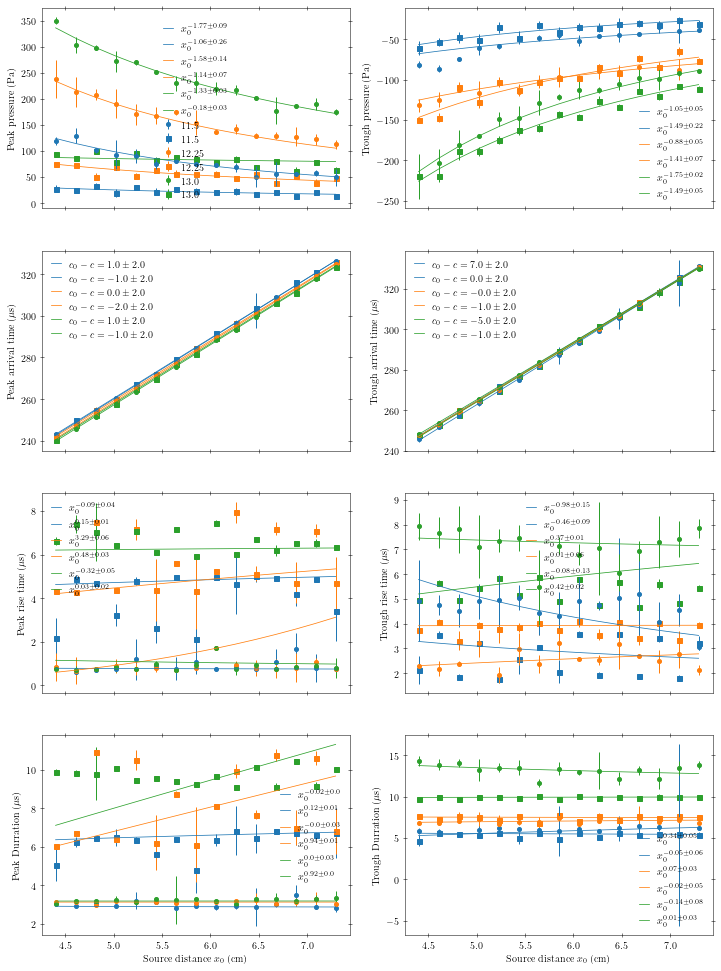

In [334]:
shoti = -1
fig, axs = plt.subplots(4, 2, figsize=(3*3.375, 3*3.4*4/3), sharex=True)
ene_names = enes
pos_mask = abs_pos < 7.5


for ene in enes[:]:
    print(ene)
    enei = list(enes).index(ene)
    c = f"C{enei}"
    fc = c
    ene_name = ene_names[enei]
    for Ci in range(2):
        if Ci == 0:
            marker="o"
        else:
            marker="s"
        dt_f, Dt_f, dt_r, Dt_r = [pulse_timings[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        ddt_f, dDt_f, ddt_r, dDt_r = [np.std(pulse_timings[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        tpeak, Ppeak, ttrough, Ptrough = [pulse_peaks[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        dtpeak, dPpeak, dttrough, dPtrough = [np.std(pulse_peaks[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        
        use_pos = abs_pos[pos_mask]
        
        dtpeak  = np.sqrt(dtpeak**2 + (1/(bd_cutoff*2))**2)
        dttrough  = np.sqrt(dttrough**2 + (1/(bd_cutoff*2))**2)
        
        popt_Ppeak, perr_Ppeak = fit_powerlaw(use_pos, Ppeak, dPpeak, [10000.0, -1.0])
        popt_tpeak, perr_tpeak = fit_line(use_pos, tpeak*1e6, dtpeak*1e6)
        popt_tpeak0 = [(c0*1e2/1e6), popt_tpeak[1]]
        popt_dt_f, perr_dt_f = fit_powerlaw(use_pos, dt_f, ddt_f, [10.0, 1.0])
        popt_Dt_f, perr_Dt_f = fit_powerlaw(use_pos, Dt_f, dDt_f, [10.0, 1.0])
        
        popt_Ptrough, perr_Ptrough = fit_powerlaw(use_pos, Ptrough, dPtrough, [-10000.0, -1.0])
        popt_ttrough, perr_ttrough = fit_line(use_pos, ttrough*1e6, dttrough)
        popt_ttrough0 = [c0*1e2/1e6, popt_ttrough[1]]
        popt_dt_r, perr_dt_r = fit_powerlaw(use_pos, dt_r, ddt_r, [10.0, 1.0])
        popt_Dt_r, perr_Dt_r = fit_powerlaw(use_pos, Dt_r, dDt_r, [10.0, 1.0])
        
        
        axs[0,0].errorbar(use_pos, Ppeak, yerr=dPpeak, 
                          mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci, label=ene_name)     
        axs[0,0].plot(use_pos, powerlaw(use_pos, *popt_Ppeak), lw=0.75, c=c, 
                      label="$x_0^{%s \pm %s}$" % (round(popt_Ppeak[1],2), round(perr_Ppeak[1],2)))
        
        axs[1,0].errorbar(use_pos, 1e6*(tpeak), yerr=1e6*dtpeak, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)        
        axs[1,0].plot(use_pos, line(use_pos, *popt_tpeak), lw=0.75, c=c,
                     label=r"$c_0-c=%s\pm %s$" % (round(c0 - popt_tpeak[0]*1e6/1e2, 0), round(perr_tpeak[0]*1e6/1e2, 0)))
        
        axs[2,0].errorbar(use_pos, 1e6*dt_f, yerr=1e6*ddt_f, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[2,0].plot(use_pos, powerlaw(use_pos, *popt_dt_f)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_dt_f[1],2), round(perr_dt_f[1],2)))
        axs[3,0].errorbar(use_pos, 1e6*Dt_f, yerr=1e6*dDt_f, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[3,0].plot(use_pos, powerlaw(use_pos, *popt_Dt_f)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_Dt_f[1],2), round(perr_Dt_f[1],2)))
            
        axs[0,1].errorbar(use_pos, Ptrough, yerr=dPtrough, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)     
        
        axs[0,1].plot(use_pos, powerlaw(use_pos, *popt_Ptrough), lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_Ptrough[1],2), round(perr_Ptrough[1],2)))
       
        axs[1,1].errorbar(use_pos, 1e6*(ttrough), yerr=1e6*dttrough, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[1,1].plot(use_pos, line(use_pos, *popt_ttrough), lw=0.75, c=c,
                     label=r"$c_0-c=%s\pm %s$" % (round(c0 - popt_ttrough[0]*1e6/1e2, 0), round(perr_tpeak[0]*1e6/1e2, 0)))
        
        axs[2,1].errorbar(use_pos, 1e6*dt_r, yerr=1e6*ddt_r, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)        
        axs[2,1].plot(use_pos, powerlaw(use_pos, *popt_dt_r)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_dt_r[1],2), round(perr_dt_r[1],2)))
        axs[3,1].errorbar(use_pos, 1e6*Dt_r, yerr=1e6*dDt_r, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[3,1].plot(use_pos, powerlaw(use_pos, *popt_Dt_r)*1e6, lw=0.75, c=c,
                      label="$x_0^{%s \pm %s}$" % (round(popt_Dt_r[1],2), round(perr_Dt_r[1],2)))
        
        for axr in axs:
            for ax in axr:
                ax.legend(frameon=False, handlelength=1)


axs[2,0].legend(frameon=False, handlelength=1, loc="upper left")
axs[0,0].set_ylabel(r"Peak pressure (Pa)")
axs[1,0].set_ylabel(r"Peak arrival time (${\rm \mu s}$)")
axs[2,0].set_ylabel(r"Peak rise time (${\rm \mu s}$)")
axs[3,0].set_ylabel(r"Peak Durration (${\rm \mu s}$)")


axs[0,1].set_ylabel("Trough pressure (Pa)")
axs[1,1].set_ylabel(r"Trough arrival time (${\rm \mu s}$)")
axs[2,1].set_ylabel(r"Trough rise time (${\rm \mu s}$)")
axs[3,1].set_ylabel(r"Trough Durration (${\rm \mu s}$)")

axs[3,0].set_xlabel("Source distance $x_0$ (cm)")
axs[3,1].set_xlabel("Source distance $x_0$ (cm)")

plt.tight_layout()
#plt.savefig("figures/laser-pos-ene-scan_pulse_params.pdf")
#plt.savefig("figures/laser-pos-ene-scan_pulse_params.png", dpi=600)


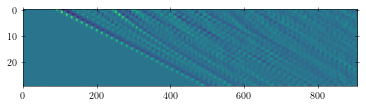

In [236]:
xs = []
for C in Cbds[-1,:]:
    t, x = C.agg.time_gate(tmin=200e-6, tmax=600e-6)
    xs.append(x)
xs = np.array(xs)
plt.imshow(xs, aspect=7)

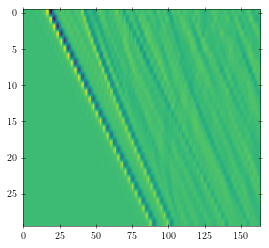

In [62]:
xs = []
for C in Cphs[-1,:]:
    t, x = C.agg.time_gate(tmin=200e-6, tmax=600e-6)
    xs.append(x)
xs = np.array(xs)
plt.imshow(xs, aspect=5)

In [339]:
def fit_powerlaw(x, y, dy, p0):
    popt, pcov = curve_fit(powerlaw, x, y, p0=p0, 
                                     bounds=[(-np.inf, -np.inf), (np.inf, np.inf)])
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def fit_line(x, y, dy):
    speed = np.mean(np.diff(x) / np.diff(y))
    print(speed)
    popt, pcov = curve_fit(line, x, y, p0=[speed, x[0]])
    perr = np.sqrt(np.diag(pcov))
    return popt, perr



0.03467558183316568
0.03535971238084034
0.03587424446666966
0.03587424446666962
0.03454060407882449
0.03456507020830632
0.035874244466669654
0.035874244466669744


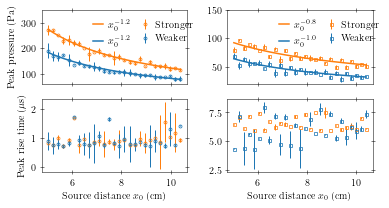

In [353]:
shoti = -1
fig, axs = plt.subplots(2, 2, figsize=(5.5, 3), sharex=True)
ene_names = enes
pos_mask = abs_pos > abs_pos[2]

ene_names = ["Stronger", "Weaker"]

for eni, ene in enumerate(enes[1::][::-1]):
    c = f"C{1-eni}"
    fc = c
    enei = list(enes).index(ene)
    ene_name = ene_names[eni]
    for Ci in range(2):
        if Ci == 0:
            marker="o"
            ls = "-"
            sensor = ""
        else:
            marker="s"
            ls = "--"
            sensor = ""
            
        dt_f, Dt_f, dt_r, Dt_r = [pulse_timings[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        ddt_f, dDt_f, ddt_r, dDt_r = [np.std(pulse_timings[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        tpeak, Ppeak, ttrough, Ptrough = [pulse_peaks[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        dtpeak, dPpeak, dttrough, dPtrough = [np.std(pulse_peaks[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        
        use_pos = abs_pos[pos_mask]
        
        dtpeak  = np.sqrt(dtpeak**2 + (1/(bd_cutoff*2))**2)
        dttrough  = np.sqrt(dttrough**2 + (1/(bd_cutoff*2))**2)
        
        popt_Ppeak, perr_Ppeak = fit_powerlaw(use_pos, Ppeak, dPpeak, [10000.0, -1.0])
        popt_tpeak, perr_tpeak = fit_line(use_pos, tpeak*1e6, dtpeak*1e6)
        popt_tpeak0 = [(c0*1e2/1e6), popt_tpeak[1]]
        popt_dt_f, perr_dt_f = fit_powerlaw(use_pos, dt_f, ddt_f, [10.0, 1.0])
        popt_Dt_f, perr_Dt_f = fit_powerlaw(use_pos, Dt_f, dDt_f, [10.0, 1.0])
        
        popt_Ptrough, perr_Ptrough = fit_powerlaw(use_pos, Ptrough, dPtrough, [-10000.0, -1.0])
        popt_ttrough, perr_ttrough = fit_line(use_pos, ttrough*1e6, dttrough)
        popt_ttrough0 = [c0*1e2/1e6, popt_ttrough[1]]
        popt_dt_r, perr_dt_r = fit_powerlaw(use_pos, dt_r, ddt_r, [10.0, 1.0])
        popt_Dt_r, perr_Dt_r = fit_powerlaw(use_pos, Dt_r, dDt_r, [10.0, 1.0])
        
        
        axs[0, Ci].errorbar(use_pos, Ppeak, yerr=dPpeak, 
                          mec=c, mfc="none", ecolor=c, ls="none", lw=1, mew=0.75,
                        ms=3, marker=marker, zorder=1-Ci,
                        label=ene_name+" "+sensor)     
        axs[0, Ci].plot(use_pos, powerlaw(use_pos, *popt_Ppeak), 
                        lw=1.5, mew=1, c=c, ls="-",
                        label="$x_0^{%.1f}$" % (popt_Ppeak[1]))
                       #label="$x_0^{%s \pm %s}$" % (round(popt_Ppeak[1],2), round(perr_Ppeak[1],2)))
       
        axs[1,Ci].errorbar(use_pos, 1e6*dt_f, yerr=1e6*ddt_f, 
                           mec=c, mfc="none", ecolor=c, ls="none", 
                           lw=1, ms=3, mew=0.75, marker=marker, zorder=1-Ci)
        #axs[1, Ci].plot(use_pos, powerlaw(use_pos, *popt_dt_f)*1e6, lw=0.75, c=c, ls=ls,
        #                label="$x_0^{%s \pm %s}$" % (round(popt_dt_f[1],2), round(perr_Dt_f[1],2)))
            
     
        axs[0, Ci].legend(frameon=False, handlelength=1, handletextpad=0.5, ncol=2, columnspacing=1, 
                          bbox_to_anchor=(1.1,1), loc="upper right")


axs[0,0].set_ylabel(r"Peak pressure (Pa)")

axs[1,0].set_ylabel(r"Peak rise time (${\rm \mu s}$)")



axs[1,0].set_xlabel("Source distance $x_0$ (cm)")


axs[1,1].set_xlabel("Source distance $x_0$ (cm)")

axs[0,0].set_ylim(top=350)
axs[0,1].set_ylim(top=150)

plt.tight_layout()
#plt.savefig("figures/laser-pos-ene-scan_pulse_params_simple.pdf")
#plt.savefig("figures/laser-pos-ene-scan_pulse_params_simple.png", dpi=600)
       

In [355]:
enes

array([11.5 , 12.25, 13.  ])

0.03467558183316568
0.03535971238084034
0.03587424446666966
0.03587424446666962


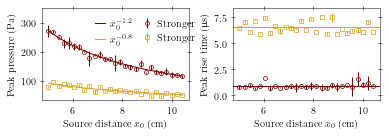

12.25
0.034620146905305293
0.0348499597905068
0.03606167521100952
0.03606167521100974
13.0
0.034741161443680106
0.035354519865733236
0.03606167521100966
0.036061675211009586


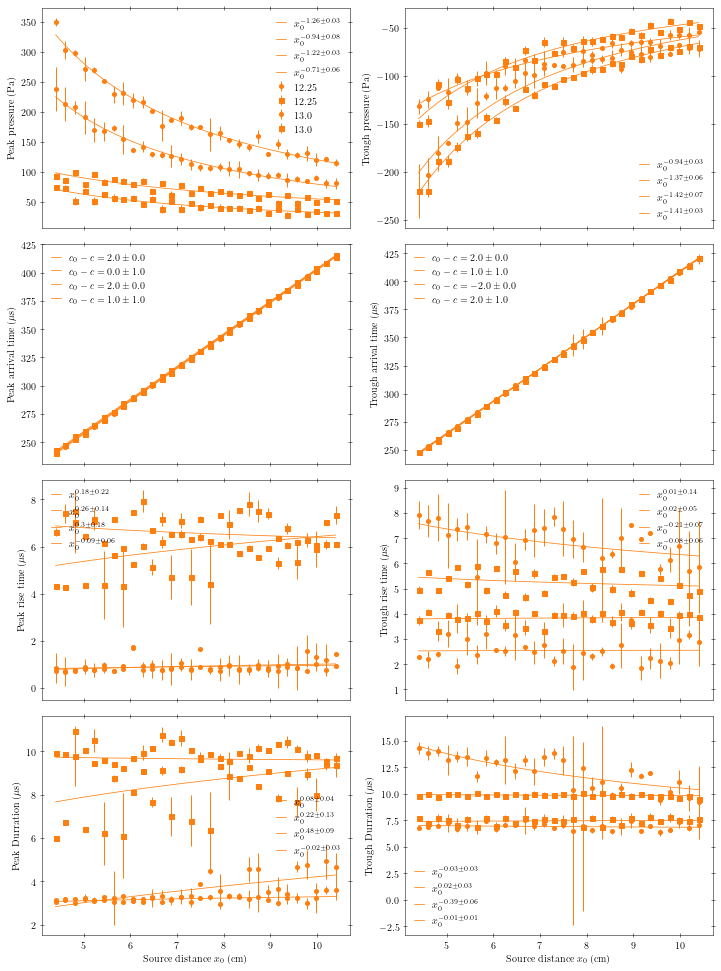

In [354]:
shoti = -1
fig, axs = plt.subplots(4, 2, figsize=(3*3.375, 3*3.4*4/3), sharex=True)
ene_names = enes
pos_mask = abs_pos < 100

for ene in enes[1:]:
    print(ene)
    c = f"C{enei}"
    fc = c
    enei = list(enes).index(ene)
    ene_name = ene_names[enei]
    for Ci in range(2):
        if Ci == 0:
            marker="o"
        else:
            marker="s"
        dt_f, Dt_f, dt_r, Dt_r = [pulse_timings[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        ddt_f, dDt_f, ddt_r, dDt_r = [np.std(pulse_timings[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        tpeak, Ppeak, ttrough, Ptrough = [pulse_peaks[Ci, enei, pos_mask, shoti, i] for i in range(4)]
        dtpeak, dPpeak, dttrough, dPtrough = [np.std(pulse_peaks[Ci, enei, pos_mask, :-1, i], axis=1) for i in range(4)]
        
        use_pos = abs_pos[pos_mask]
        
        dtpeak  = np.sqrt(dtpeak**2 + (1/(bd_cutoff*2))**2)
        dttrough  = np.sqrt(dttrough**2 + (1/(bd_cutoff*2))**2)
        
        popt_Ppeak, perr_Ppeak = fit_powerlaw(use_pos, Ppeak, dPpeak, [10000.0, -1.0])
        popt_tpeak, perr_tpeak = fit_line(use_pos, tpeak*1e6, dtpeak*1e6)
        popt_tpeak0 = [(c0*1e2/1e6), popt_tpeak[1]]
        popt_dt_f, perr_dt_f = fit_powerlaw(use_pos, dt_f, ddt_f, [10.0, 1.0])
        popt_Dt_f, perr_Dt_f = fit_powerlaw(use_pos, Dt_f, dDt_f, [10.0, 1.0])
        
        popt_Ptrough, perr_Ptrough = fit_powerlaw(use_pos, Ptrough, dPtrough, [-10000.0, -1.0])
        popt_ttrough, perr_ttrough = fit_line(use_pos, ttrough*1e6, dttrough)
        popt_ttrough0 = [c0*1e2/1e6, popt_ttrough[1]]
        popt_dt_r, perr_dt_r = fit_powerlaw(use_pos, dt_r, ddt_r, [10.0, 1.0])
        popt_Dt_r, perr_Dt_r = fit_powerlaw(use_pos, Dt_r, dDt_r, [10.0, 1.0])
        
        
        axs[0,0].errorbar(use_pos, Ppeak, yerr=dPpeak, 
                          mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci, label=ene_name)     
        axs[0,0].plot(use_pos, powerlaw(use_pos, *popt_Ppeak), lw=0.75, c=c, 
                      label="$x_0^{%s \pm %s}$" % (round(popt_Ppeak[1],2), round(perr_Ppeak[1],2)))
        
        axs[1,0].errorbar(use_pos, 1e6*(tpeak), yerr=1e6*dtpeak, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)        
        axs[1,0].plot(use_pos, line(use_pos, *popt_tpeak), lw=0.75, c=c,
                     label=r"$c_0-c=%s\pm %s$" % (round(c0 - popt_tpeak[0]*1e6/1e2, 0), round(perr_tpeak[0]*1e6/1e2, 0)))
        
        axs[2,0].errorbar(use_pos, 1e6*dt_f, yerr=1e6*ddt_f, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[2,0].plot(use_pos, powerlaw(use_pos, *popt_dt_f)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_dt_f[1],2), round(perr_dt_f[1],2)))
        axs[3,0].errorbar(use_pos, 1e6*Dt_f, yerr=1e6*dDt_f, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[3,0].plot(use_pos, powerlaw(use_pos, *popt_Dt_f)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_Dt_f[1],2), round(perr_Dt_f[1],2)))
            
        axs[0,1].errorbar(use_pos, Ptrough, yerr=dPtrough, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)     
        
        axs[0,1].plot(use_pos, powerlaw(use_pos, *popt_Ptrough), lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_Ptrough[1],2), round(perr_Ptrough[1],2)))
       
        axs[1,1].errorbar(use_pos, 1e6*(ttrough), yerr=1e6*dttrough, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[1,1].plot(use_pos, line(use_pos, *popt_ttrough), lw=0.75, c=c,
                     label=r"$c_0-c=%s\pm %s$" % (round(c0 - popt_ttrough[0]*1e6/1e2, 0), round(perr_tpeak[0]*1e6/1e2, 0)))
        
        axs[2,1].errorbar(use_pos, 1e6*dt_r, yerr=1e6*ddt_r, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)        
        axs[2,1].plot(use_pos, powerlaw(use_pos, *popt_dt_r)*1e6, lw=0.75, c=c,
                     label="$x_0^{%s \pm %s}$" % (round(popt_dt_r[1],2), round(perr_dt_r[1],2)))
        axs[3,1].errorbar(use_pos, 1e6*Dt_r, yerr=1e6*dDt_r, mec=c, mfc=fc, ecolor=c, ls="none", lw=1, ms=5-1*(1-Ci), marker=marker, zorder=1-Ci)
        axs[3,1].plot(use_pos, powerlaw(use_pos, *popt_Dt_r)*1e6, lw=0.75, c=c,
                      label="$x_0^{%s \pm %s}$" % (round(popt_Dt_r[1],2), round(perr_Dt_r[1],2)))
        
        for axr in axs:
            for ax in axr:
                ax.legend(frameon=False, handlelength=1)

        

axs[2,0].legend(frameon=False, handlelength=1, loc="upper left")
axs[0,0].set_ylabel(r"Peak pressure (Pa)")
axs[1,0].set_ylabel(r"Peak arrival time (${\rm \mu s}$)")
axs[2,0].set_ylabel(r"Peak rise time (${\rm \mu s}$)")
axs[3,0].set_ylabel(r"Peak Durration (${\rm \mu s}$)")


axs[0,1].set_ylabel("Trough pressure (Pa)")
axs[1,1].set_ylabel(r"Trough arrival time (${\rm \mu s}$)")
axs[2,1].set_ylabel(r"Trough rise time (${\rm \mu s}$)")
axs[3,1].set_ylabel(r"Trough Durration (${\rm \mu s}$)")

axs[3,0].set_xlabel("Source distance $x_0$ (cm)")
axs[3,1].set_xlabel("Source distance $x_0$ (cm)")

plt.tight_layout()
#plt.savefig("figures/laser-pos-ene-scan_pulse_params.pdf")
#plt.savefig("figures/laser-pos-ene-scan_pulse_params.png", dpi=600)
       

# High res

In [194]:
experiment_ders

['/mnt/ext/data/20220722/bead1/slow-phone_1000-shots_ene-scan',
 '/mnt/ext/data/20220722/bead1/slow-phone_baseline',
 '/mnt/ext/data/20220722/bead1/slow-phone_baseline_V2',
 '/mnt/ext/data/20220722/bead1/slow-phone_baseline_V3',
 '/mnt/ext/data/20220722/bead1/slow-phone_ene-pos-scan_1ms-delay',
 '/mnt/ext/data/20220722/bead1/slow-phone_ene-pos-scan_1ms-delay_V2',
 '/mnt/ext/data/20220722/bead1/slow-phone_hi-res-pos-scan_1ms-delay_V3',
 '/mnt/ext/data/20220722/bead1/slow-phone_hi-respos-scan_1ms-delay_V2']

In [444]:
fnames_ph = sort_fnames(find_files(experiment_ders[7]))
musphere_response = make_musphere_response(C0, response="bassetbound", impedance="plane", r0=0)
bd_cutoff = 1000e3

enes = []
poss = []
for fname in fnames_ph:
    C = Collection(fname)
    poss.append(C.pos)
    enes.append(C.ene)
poss = np.unique(poss)
abs_pos = poss + pos0
enes = np.unique(enes)

enes = enes[:]
fnamei = len(poss)
Cbds = np.zeros((len(enes), len(poss)), dtype="object")
Cphs = np.zeros((len(enes), len(poss)), dtype="object")
fnamei=0
for enei, ene in enumerate(enes):
    for posi, pos in enumerate(poss):
        fname = fnames_ph[fnamei]
        Cbd = load_collection(fname, "X", musphere_response, 
                      differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=laser_delay, invert=True)
        Cph = load_collection(fname, "Y", mic_response, 
                      differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=laser_delay+15e-6, invert=False)
        Cbd.aggrigate()
        Cph.aggrigate()
        fnamei += 1
        Cbds[enei, posi] = Cbd
        Cphs[enei, posi] = Cph      

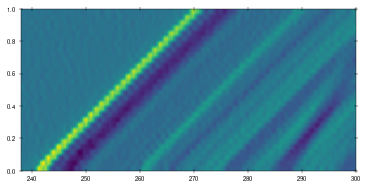

In [447]:
tmin=238e-6
tmax=300e-6
xs = []
for C in Cbds[-1,:]:
    t, x = C.agg.time_gate(tmin=tmin, tmax=tmax)
    xs.append(x)
xs = np.array(xs)
plt.imshow(xs, aspect=30, origin="lower", extent=[1e6*tmin, 1e6*tmax, poss[0], poss[-1]])

IndexError: index 145 is out of bounds for axis 1 with size 141

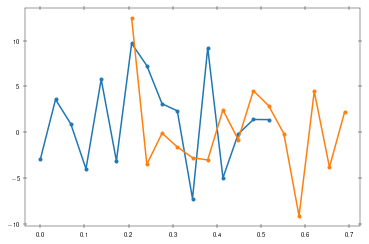

In [443]:
plt.plot(poss[:16], xs[:16, 115], marker=".")

plt.plot(poss[6:-9], xs[6:-9, 130], marker=".")

plt.plot(poss[12:], xs[12:, 145], marker=".")